In [49]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi
import lnPi.stability
import lnPi.monoutils

#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


# create a reference lnPi_phases for bulk case

In [106]:
import lnPi.monoutils_vec

In [126]:
reload(lnPi.utils)

import lnPi.serieswrapper
reload(lnPi.serieswrapper)

import lnPi.xlnPi_vec
reload(lnPi.xlnPi_vec)

reload(lnPi.segment)
import lnPi.stability_vec
reload(lnPi.stability_vec)

pe = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = dict(volume=volume, temp=temp, beta=1/temp)
lnz = beta * mu

# reference masked lnPi
ref = lnPi.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat',fill_value=np.nan,
                                      lnz=lnz, state_kws=state_kws, extra_kws={'PE':pe}).zeromax()

# Phase Creator
PhaseCreator = lnPi.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref)
build_phases = PhaseCreator.build_phases_mu([None])




p = build_phases(-13.0)
p.xgce.betaOmega()

/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.xlnPi_vec.xrlnPiVec'> under name 'vgce' for type <class 'lnPi.core.MaskedlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:344: AccessorRegistrationWarning: registration of name 'wlnPi' for type <class 'lnPi.lnpicollections.CollectionPhases'> is overriding a preexisting attribute with the same name.
  return cls._register_listaccessor(names, accessor_wrapper=_CachedListAccessorWrapper, cache_list=cache_list)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.segment.wlnPi'> under name 'wlnPi' for type <class 'lnPi.lnpicollections.Phases'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)


<xarray.DataArray 'betaOmega' (phase: 2)>
array([ -1.25806 , 384.896142])
Coordinates:
    lnz_0    float64 -13.0
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [127]:
PhaseCreator_s = lnPi.segment.PhaseCreator(nmax=2, 
                                           tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                           phases_factory=lnPi.serieswrapper.CollectionlnPi.from_list,
                                            ref=ref)
build_phases_s = PhaseCreator_s.build_phases_mu([None])


In [129]:
lnzs = np.linspace(-12, -5, 20)

In [130]:
with lnPi.set_options(tqdm_leave=True):
    o = lnPi.serieswrapper.CollectionlnPi.from_builder(lnzs, build_phases_s)

In [131]:
with lnPi.set_options(tqdm_leave=True):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases, set_index=['lnz_0','phase'])

In [132]:
o.spinodal(2, build_phases_s)
o.binodal(2, build_phases_s)

## create a collection

In [133]:
with lnPi.set_options(tqdm_use=True, tqdm_leave=True, joblib_use=True):
    o = lnPi.serieswrapper.CollectionlnPi.from_builder(lnzs, build_phases_s)

In [134]:
o.spinodal(2, build_phases_s, inplace=True, unstack=False)
o.binodal(2, build_phases_s, inplace=True, unstack=False)

o = o.stability_append()

In [45]:
(
    o.spinodal.access
    .xgce.betaOmega()
    .unstack()
    .pipe(lambda x: x.sel(spinodal=x.phase))
    
#     .pipe(lambda x: x.sel(sample=x.spinodal==x.phase))
#     .unstack()
)

<xarray.DataArray 'betaOmega' (phase: 2, lnz_0: 2)>
array([[       nan, -16.299163],
       [770.339413,        nan]])
Coordinates:
    beta      float64 1.429
    temp      float64 0.7
    volume    int64 729
    spinodal  (phase) int64 0 1
  * lnz_0     (lnz_0) float64 -13.7 -10.67
  * phase     (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    dims_rec:       ['sample']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

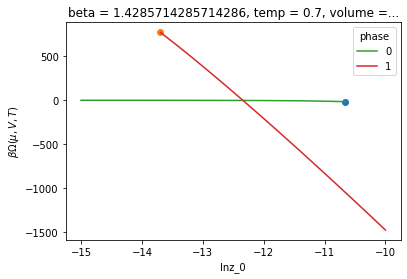

In [48]:
(
    o.spinodal.access.xgce.betaOmega().unstack()
    .pipe(lambda x: x.where(x.phase == x.spinodal, drop=True))
    .max('phase')
    .plot(hue='spinodal', marker='o')
)

o.xgce.betaOmega().plot(hue='phase')

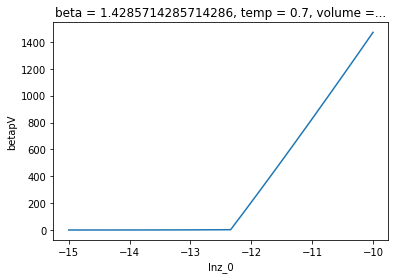

In [3687]:
o.xgce.table(mask_stable=True, dim_to_suffix='component').betapV.plot(hue='phase')

In [3688]:
# mu min/max

In [3689]:
import lnPi.monoutils_vec
reload(lnPi.monoutils_vec)

<module 'lnPi.monoutils_vec' from '/Users/wpk/Documents/python/lnPi/monoutils_vec.py'>

In [3690]:
o_course, o = lnPi.monoutils_vec.limited_collection(build_phases_s, offsets=[-10, +12],
                                                    dlnz=0.1, digits=2,
                                                    rho_min=0.0001, edge_distance_min=8, limit_course=True)


In [3691]:
# calc stability 
o_course.spinodal(2, build_phases_s, inplace=True)
o_course.binodal(2, build_phases_s, inplace=True)
# append to o
o = o.stability_append(o_course)

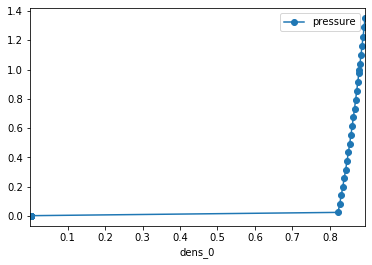

In [3692]:
table = o.xgce.table(['dens','pressure'], mask_stable=True, dim_to_suffix='component')

table.to_dataframe().plot('dens_0','pressure',marker='o')

In [3693]:
# test saving

In [3694]:
da = o.to_dataarray()
o2 = lnPi.serieswrapper.CollectionlnPi.from_dataarray(ref, da)

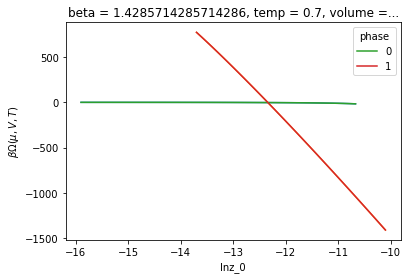

In [3695]:
o.xgce.betaOmega().plot(hue='phase')
o2.xgce.betaOmega().plot(hue='phase')

# bulk 065

In [135]:
reload(lnPi.serieswrapper)
reload(lnPi.segment)
reload(lnPi.xlnPi_vec)

/Users/wpk/Documents/python/lnPi/extensions.py:344: AccessorRegistrationWarning: registration of name 'wlnPi' for type <class 'lnPi.lnpicollections.CollectionPhases'> is overriding a preexisting attribute with the same name.
  return cls._register_listaccessor(names, accessor_wrapper=_CachedListAccessorWrapper, cache_list=cache_list)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.segment.wlnPi'> under name 'wlnPi' for type <class 'lnPi.lnpicollections.Phases'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.xlnPi_vec.xrlnPiVec'> under name 'vgce' for type <class 'lnPi.core.MaskedlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)


<module 'lnPi.xlnPi_vec' from '/Users/wpk/Documents/python/lnPi/xlnPi_vec.py'>

In [136]:
reload(lnPi.monoutils_vec)
reload(lnPi.stability_vec)


<module 'lnPi.stability_vec' from '/Users/wpk/Documents/python/lnPi/stability_vec.py'>

In [137]:
beta = 1.0 / 0.65

In [138]:
ref_bulk = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat', lnz=-4.453015418106743E+00 /0.65,
                               state_kws=dict(volume=1000.0E0,beta=1./0.65000E0))

In [139]:
phase_creator_bulk = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_bulk, 
                                               phases_factory=lnPi.serieswrapper.CollectionlnPi.from_list,
                                         merge_kws=dict(efac=0.5), tag_phases=tag_phases2)
build_phases_bulk = phase_creator_bulk.build_phases_mu([None])

In [140]:
c_course_bulk, c_bulk = lnPi.monoutils_vec.limited_collection(build_phases_bulk, lnz_range=[-20, 0.0],
                                                              dlnz=0.01, 
                                                              digits=2, 
                                                              edge_distance_min=8,
                                                              limit_course=True)

In [147]:
c[0][0].xgce.molfrac.sel(component=0)

<xarray.DataArray 'molfrac' ()>
array(1.)
Coordinates:
    lnz_0    float64 -12.0
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf x}(\mu,V,T)$

In [3702]:
c_course_bulk.spinodal(2, build_phases_bulk, inplace=True)
c_course_bulk.binodal(2, build_phases_bulk, inplace=True)

In [3703]:
#c_bulk = c_bulk.stability_append(c_course_bulk)

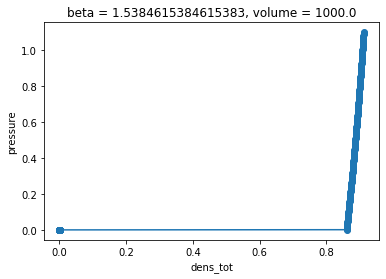

In [3704]:
(
    c_bulk.xgce.table(['dens_tot','pressure'], mask_stable=True)
     .swap_dims({'lnz_0':'dens_tot'})
     .pressure.plot(marker='o')
    
)

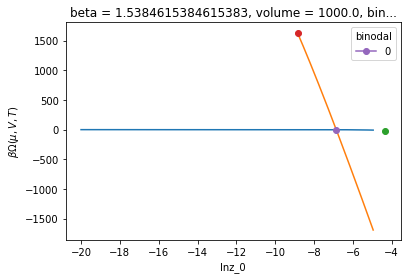

In [3705]:
c_bulk.xgce.betaOmega().plot(hue='phase')

(
    c_course_bulk.spinodal.access.xgce.betaOmega()
    
    .pipe(lambda x: x.sel(phase = x.spinodal))

    .plot(hue='spinodal', marker='o')
)

(
    c_course_bulk.binodal.access.xgce.betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue='binodal',marker='o')
)

# confined

In [3706]:
reload(lnPi.monoutils_vec)

<module 'lnPi.monoutils_vec' from '/Users/wpk/Documents/python/lnPi/monoutils_vec.py'>

In [3707]:
ref_conf = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',
                                       lnz=-0.500000E+01/0.65,state_kws=dict(volume=7000.,beta=1./0.65000E0))


phase_creator_conf = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_conf, 
                                               phases_factory=lnPi.serieswrapper.CollectionlnPi.from_list,
                                              merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

build_phases_conf = phase_creator_conf.build_phases_mu([None])

In [3723]:
phase_creator_ = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_conf, 
                                              merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

build_phases_ = phase_creator_.build_phases_mu([None])

In [3737]:
c_conf.index.levels[0]

Float64Index([ -20.0, -19.99, -19.98, -19.97, -19.96, -19.95, -19.94, -19.93,
              -19.92, -19.91,
              ...
               -6.95,  -6.94,  -6.93,  -6.92,  -6.91,   -6.9,  -6.89,  -6.88,
               -6.87,  -6.86],
             dtype='float64', name='lnz_0', length=1318)

In [3770]:
cc = lnPi.CollectionPhases.from_builder(c_conf.index.levels[0], build_phases_)

In [3708]:
mx = c_course_bulk.binodal.access.iloc[0].lnz[build_phases_bulk.index]
lnz_range = [-20, mx]

In [3759]:
c_course_conf, c_conf = lnPi.monoutils_vec.limited_collection(build_phases_conf, 
                                                              lnz_range=lnz_range,
                                                              dlnz=0.01, 
                                                              digits=2, 
                                                              edge_distance_min=8,
                                                              limit_course=True)

In [3760]:
c_course_conf.spinodal(2, build_phases_conf, inplace=True)
c_course_conf.binodal(2, build_phases_conf, inplace=True)

In [3761]:
c_conf = c_conf.stability_append(c_course_conf)

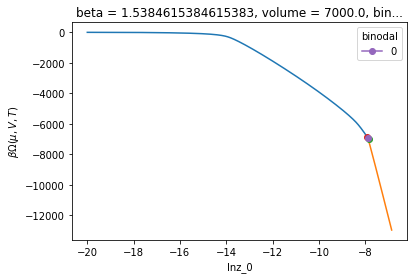

In [3774]:
c_conf.xgce.betaOmega().plot(hue='phase')

(
    c_conf.spinodal.access.xgce.betaOmega()
    .pipe(lambda x: x.sel(spinodal=x.phase))
    .plot(hue='phase', marker='o')
)

(
    c_conf.binodal.access.xgce.betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue='binodal', marker='o')
)

In [3778]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


# make isotherm

In [3779]:
psat = c_course_bulk.binodal.appender.xgce.pressure().sel(phase=0).squeeze().values
psat

array(0.00069573)

In [3780]:
c_bulk_ = lnPi.serieswrapper.CollectionlnPi.from_builder(c_conf._get_level('lnz_0'), build_phases_bulk)

In [3781]:
table_bulk = (
    c_bulk_.xgce.table(['pressure'], mask_stable=True)
    .assign(pscaled=lambda x: x.pressure / psat)
    .drop(['volume'])
)

In [3782]:
table_conf = (
    c_conf.xgce.table(['ntot'])
    .drop('volume')
)

In [3783]:
isotherm = (
    xr.merge((table_bulk.pscaled, table_conf.ntot), join='inner')
    .set_coords('pscaled')

)

In [3784]:
lnz_spin = c_conf.spinodal.access._get_level('lnz_0')

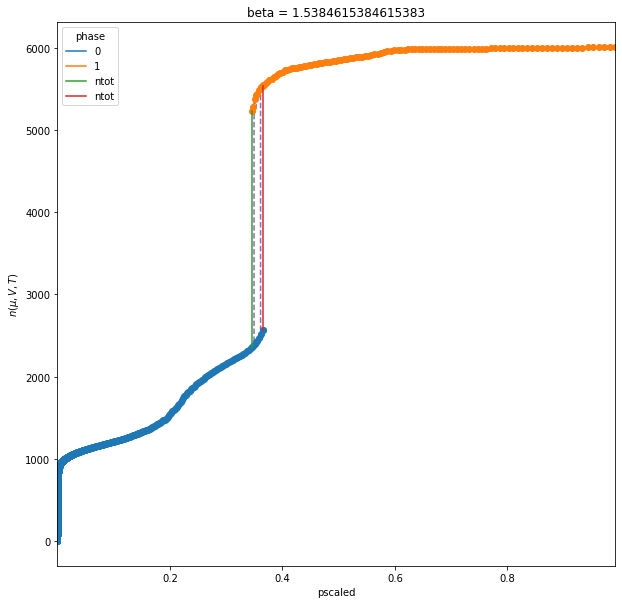

In [3385]:
fig, ax = plt.subplots(figsize=(10,10))
(
    isotherm.ntot
    .swap_dims({'lnz_0':'pscaled'})
    .plot(hue='phase', marker='o')
)

for meta, g in isotherm.sel(lnz_0=lnz_spin).to_dataframe().reset_index().groupby('lnz_0'):
    g.plot('pscaled','ntot', ax=plt.gca())
    
plt.plot(df.pscaled,df.rho, marker='o',mfc='None', ls='--',zorder=-1, ms=4)
# plt.xlim(0.3, 0.45)
# plt.ylim(5000, 6000)

In [251]:
# new bulk on same spacinf
c_bulk = lnPi.CollectionPhases.from_builder(c_conf.lnz[:,0], build_phases_bulk, set_index=['lnz_0','phase'])

In [252]:
lnz_spin = c_conf.spinodals.access.lnz[:,0]

In [253]:
psat = c_course_bulk.binodals.access.xgce_prop.pressure().values.flatten()[0]

table_bulk = (
    c_bulk.xgce_prop.table(['pressure'], mask_stable=True)
    .assign(pscaled=lambda x: x.pressure / psat)
    .drop('volume')
)

table_conf = (
    c_conf.xgce_prop.table(['ntot'])
    .drop('volume')
)

isotherm = (
    xr.merge((table_bulk.pscaled, table_conf.ntot))
    .set_coords('pscaled')
    .ntot
)
isotherm

(0, 1.0)

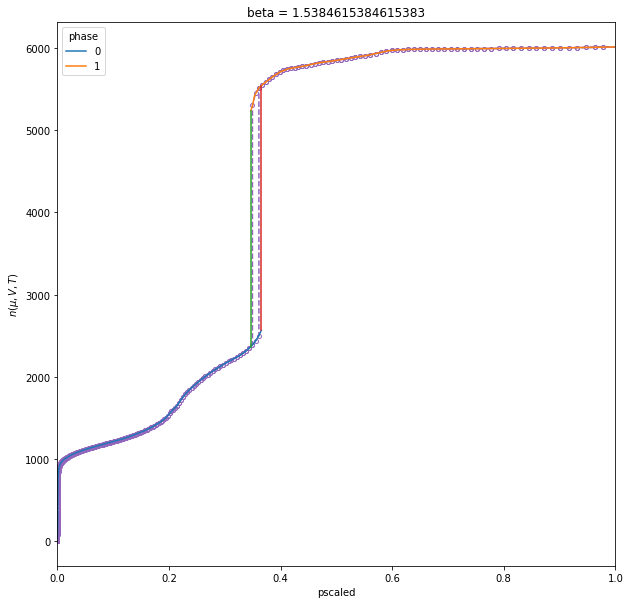

In [261]:
fig,ax = plt.subplots(figsize=(10,10))

isotherm.swap_dims({'lnz_0':'pscaled'}).plot(hue='phase')

for meta, g in isotherm.sel(lnz_0=lnz_spin).to_dataframe().reset_index().groupby('lnz_0'):
    plt.plot(g['pscaled'],g['ntot'])
    
plt.plot(df.pscaled,df.rho, marker='o',mfc='None', ls='--',zorder=-1, ms=4)
plt.gca().set_xlim(0,1.0)